Calculate TPR from measured PDD. The PDDs were measured at 100cm FSD, so the field size is set at the surface, and dref is 5cm

Reproduce work that used VBA. Note that data is loaded as string, so have to be carefulf to convert to floats.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

## Load the PDD data

In [2]:
PDD = pd.read_table('PDD_6MV.csv', sep= ",", index_col=0).astype(np.float); # Load the PDD, convert strings to floats

In [3]:
PDD.index = PDD.index.map(int)
PDD.columns = PDD.columns.map(int)   # map values to floats 

PDD.index.rename('Depth_mm', inplace=True)  # rename the cols and index
PDD.columns.rename('Fields_mm', inplace=True)

In [4]:
PDD.head()

Fields_mm,10,20,30,40,50,60,70,80,100,120,150,200,250,300,400
Depth_mm,,,,,,,,,,,,,,,
0,42.0,43.0,44.8,45.3,46.6,47.3,48.7,49.0,50.8,51.9,54.6,58.6,62.3,65.3,69.3
1,49.0,50.0,50.4,50.7,52.0,52.8,54.2,54.4,56.3,56.8,59.5,63.4,66.9,69.8,73.5
2,56.0,57.0,58.6,58.7,60.3,60.9,61.8,62.4,64.1,64.1,66.7,70.1,73.2,75.8,79.1
3,66.2,67.2,68.2,67.9,69.6,70.2,70.3,71.4,72.8,72.5,74.7,77.7,80.2,82.3,84.8
4,74.8,75.8,76.8,76.4,77.8,78.3,78.1,79.3,80.4,80.1,81.8,84.1,86.1,87.7,89.5


In [5]:
PDD.lookup([0], [10]).item()    # lookup depth and field

42.0

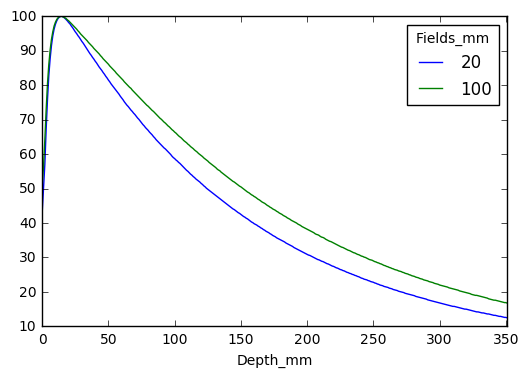

In [6]:
PDD[[20,100]].plot()

In [7]:
fields = PDD.columns.values.astype(np.float)
depths = PDD.index.values.astype(np.float)

PDDInterp = interpolate.interp2d(fields, depths, PDD.as_matrix(), kind='linear')  # create the 2D interp

def PDD_(field, depth):  # helper function to get a pdd
    return PDDInterp(field, depth).item()

PDD_(25.0, 3.5)

72.0

## Load normalised PSF

In [8]:
NPSF = pd.read_table('NPSF.csv', delimiter= ",").transpose()
NPSF.columns = NPSF.iloc[0]  #get columns columns
NPSF = NPSF.iloc[1:]
NPSF.head()

Field (mm),NPSF
10,0.967
20,0.971
30,0.975
40,0.979
50,0.983


In [9]:
NPSF_interp = interpolate.interp1d(NPSF.index.values.astype(np.float), NPSF['NPSF'].values.astype(np.float)) 

def NPSF_(field):  # helper funtion to get the NPSF given a field size
    return NPSF_interp(field).item()

NPSF_(44.23)

0.980692

# Calculated TPR

In [10]:
def TPR(field_mm, depth_mm, depth_ref_mm):   # copied straigth from EXCEL
    # 'Calculate TPR for SSD f = 100cm'
    f = 1000.0   # The SSD under ref conditions, 100 cm
    S = field_mm
    d = depth_mm
    dr = depth_ref_mm
    correction = ((f + d) / (f + dr)) ** 2
    PDD_d = PDD_(((S * f) / (f + d)), d)
    PDD_dr = PDD_(((S * f) / (f + dr)), dr)
    NPSF_d = NPSF_(((S * f) / (f + d)))
    NPSF_dr = NPSF_(((S * f) / (f + dr)))
    TPR = (PDD_d / PDD_dr) * (NPSF_d / NPSF_dr) * correction
    return TPR

depth_ref_mm = 50.0 # the reference depth, cm
depth_mm = 100.0 # the depth to calculate TPR, cm
field_mm = 100.0  # calc for single field size, at surface under ref conditions
print(TPR(field_mm, depth_mm, depth_ref_mm))   # 0.84 agrees with EXCEL calcs

0.8397410114462159


# Generate TPR table

As with my project work I had to iterate over the data frame to apply the funciton taking in index/column values

In [11]:
i = len(fields)
j = len(depths)
wilcox_data = np.zeros((i,j))  # init an empty array

In [12]:
j = 0
for field in fields:
    i = 0
    for depth in depths:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['diff']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

NameError: name 'd' is not defined

In [ ]:
TPR_df = pd.DataFrame(data=wilcox_data, index=depths, columns=fields)  # 1st row as the column names